#### Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:
#### В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
#### Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
#### Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1
    
<b>Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).<b/>

### Импортируем нужные библиотеки

In [54]:
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import pingouin as pg
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Считаем данные

In [55]:
auth = 'problem1-auth_data.csv'
reg = 'problem1-reg_data.csv'

In [56]:
auth = pd.read_csv(auth, sep=';')
reg = pd.read_csv(reg, sep=';')

##### Посмотрим на датафрейм reg. Проверим количество строк, тип данных, пропущенные значения, дубли.

In [57]:
reg.shape

(1000000, 2)

In [58]:
reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [59]:
reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [60]:
reg.duplicated().sum()

0

<b> Пропусков и дублей в данных нет <b/>

##### Посмотрим на датафрейм auth. Проверим количество строк, тип данных, пропущенные значения, дубли.

In [61]:
auth.shape

(9601013, 2)

In [62]:
auth.dtypes

auth_ts    int64
uid        int64
dtype: object

In [63]:
auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [64]:
auth.duplicated().sum()

0

<b> Пропусков и дублей в данных нет <b/>

##### Преобразуем даты в удобный для дальнейшей работы формат.

In [65]:
reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], unit='s').dt.date
reg

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5
...,...,...
999995,2020-09-23,1110618
999996,2020-09-23,1110619
999997,2020-09-23,1110620
999998,2020-09-23,1110621


In [66]:
auth['auth_ts'] = pd.to_datetime(auth['auth_ts'], unit='s').dt.date
auth

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2
...,...,...
9601008,2020-09-23,1110618
9601009,2020-09-23,1110619
9601010,2020-09-23,1110620
9601011,2020-09-23,1110621


##### Посмотрим, как менялась активность пользователей за весь времнной промежуток, представленный в данных.

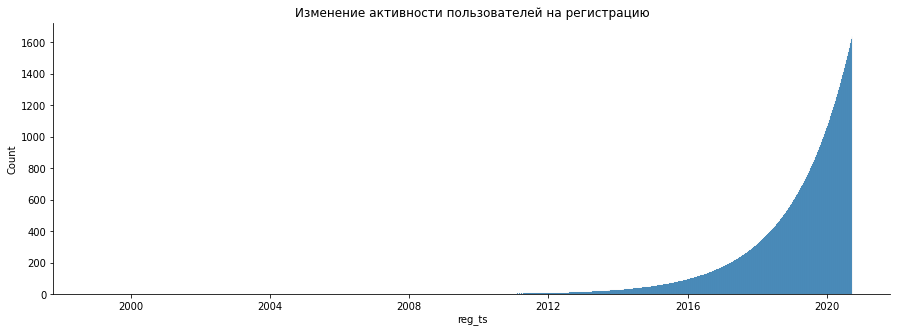

In [67]:
plt.figure(figsize=(15, 5))
sns.histplot(reg, x='reg_ts').set(title='Изменение активности пользователей на регистрацию')
sns.despine()

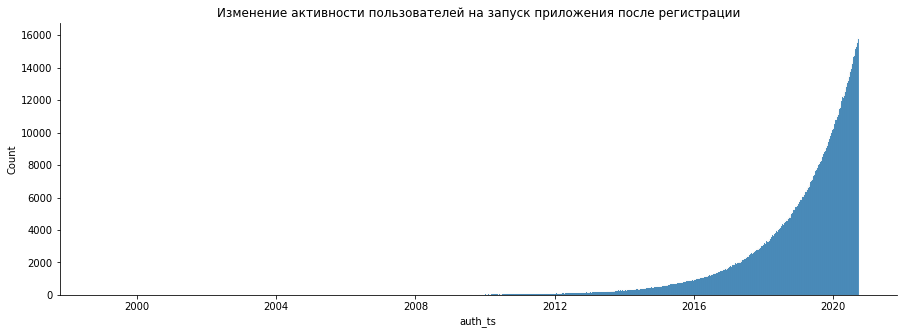

In [68]:
plt.figure(figsize=(15, 5))
sns.histplot(auth, x='auth_ts').set(title='Изменение активности пользователей на запуск приложения после регистрации')
sns.despine()

<b> Можем сделать вывод, что значительный рост активности пользователей наблюдается с 2012 года.<b/>

## Перейдем к расчету функции retention
- reg - данные о времени регистрации
- auth - данные о времени захода пользователей в игру
- start_date - начальная дата
- end_date - конечная дата
- days - период

In [70]:
def retention(reg, auth, start_date, end_date, days):
    
    reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
    auth = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')
    
    reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], unit='s').dt.date
    auth['auth_ts'] = pd.to_datetime(auth['auth_ts'], unit='s').dt.date

    # Объединим таблицы reg и auth
    reg_auth = auth.merge(reg, on='uid')   
    
    # Вычислим количество дней между днем захода в приложение и днем регистрации, укажем временной промежуток
    reg_auth['days_number'] = (reg_auth.auth_ts - reg_auth.reg_ts).dt.days
    reg_auth = reg_auth[reg_auth.days_number <= days]
    
    reg_auth = reg_auth[pd.to_datetime(reg_auth['reg_ts'])
                        .between(pd.to_datetime(start_date), pd.to_datetime(end_date))]
    
    # Сгруппируем в когорты
    cohorts = reg_auth.groupby(['reg_ts', 'days_number']).agg({'uid': pd.Series.nunique}).reset_index() 
    cohorts_pivot = cohorts.pivot(index='reg_ts', columns='days_number', values='uid')
    retention = cohorts_pivot.divide(cohorts_pivot[0], axis=0)
    
    retention[0] = cohorts_pivot[0].apply(int)
    
    # Построим тепловую карту
    plt.figure(figsize=(20, 15))
    plt.title('Retention', fontsize=20)
    sns.heatmap(retention, annot=True, vmin=0.0, vmax=0.09, 
                cmap='Blues', linewidths=1, linecolor='grey', fmt='.2g')
    plt.xlabel('Дни после регистрации', fontsize=15)
    plt.ylabel('Дата регистрации', fontsize=15)
    
    plt.show()

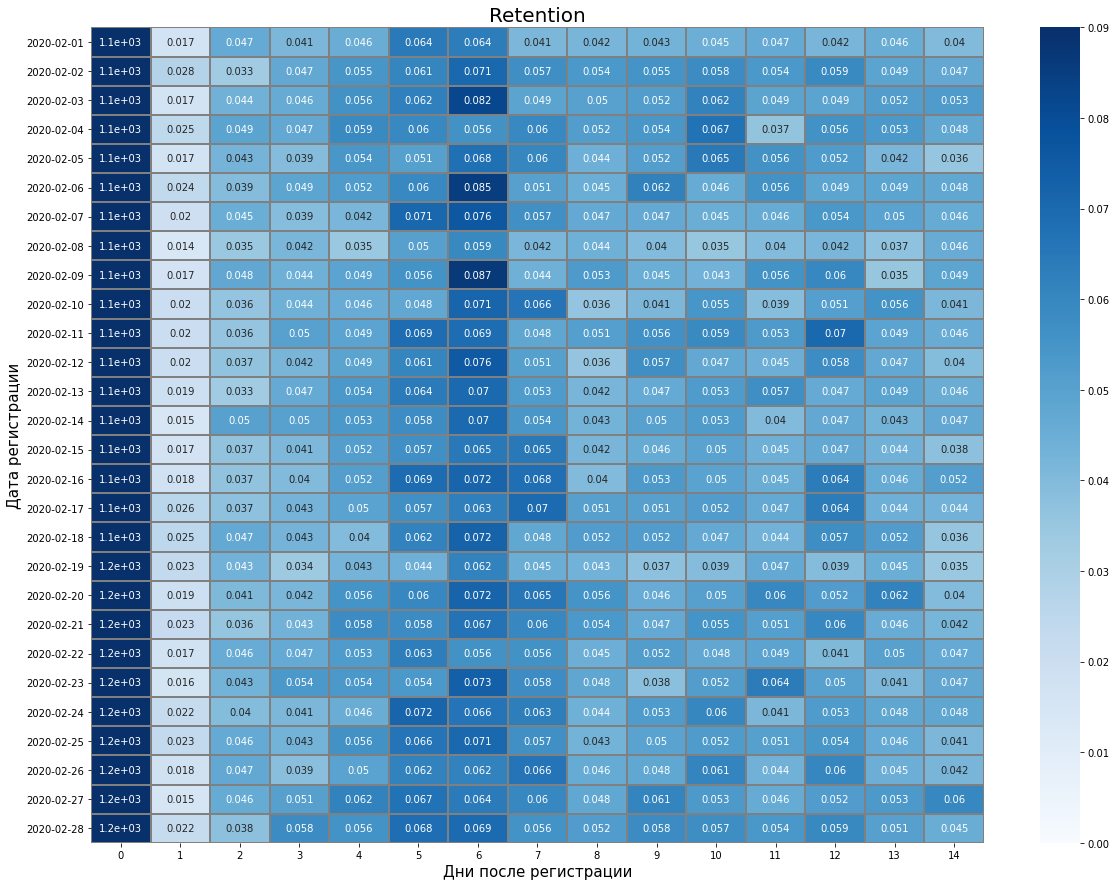

In [71]:
retention(reg, auth, '2020-02-01', '2020-02-28', 14)

<b> Максимальный retention мы наблюдаем на 5-7 день после даты регистрации, затем пользователи начинают терять интерес. Для решения данной проблемы можно попробовать ввести систему поощрений в виде:бонусов, подарков и т.п<b/>

## Задание 2
- Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

- Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [74]:
ab_test = 'Проект_1_Задание_2.csv'
ab_test = pd.read_csv(ab_test, sep=';')
ab_test

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


##### Посмотрим на датафрейм ab_test. Проверим количество строк, тип данных, пропущенные значения, дубли.

In [75]:
ab_test.shape

(404770, 3)

In [76]:
ab_test.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [77]:
ab_test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [78]:
ab_test.duplicated().sum()

0

<b> Пропусков и дублей в данных нет. <b/>

<b> Посмотрим на распределение revenue в тестовой и контрольной группах и проверим, являеется ли распределение нормальным.
<b/>

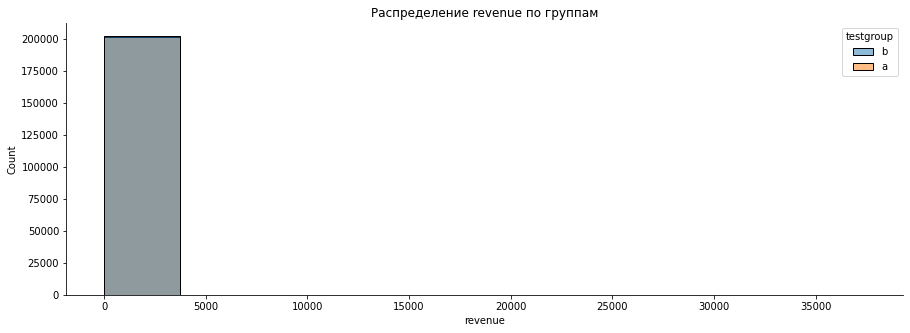

In [81]:
plt.figure(figsize=(15, 5))
sns.histplot(data=ab_test, x='revenue', hue='testgroup', bins=10).set(title='Распределение revenue по группам')
sns.despine()

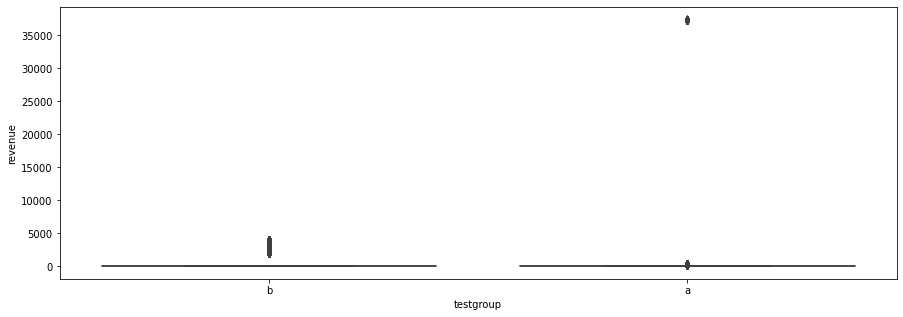

In [82]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=ab_test, x='testgroup', y='revenue')

<b> Построили гистограмму и боксплот. На гистограмме значения признака для обеих групп сосредоточены в левой части графика и не доходят до 5000. На боксплоте большая часть значений сосредоточена на нуле, и мы видим 1 диапазон значений, отличный от нуля, у тестовой группы и 2 подобных диапазона у контрольной группы. <b/>

In [83]:
# Оставляем в выборке только платящих пользователей
users_pay = ab_test.query('revenue > 0')

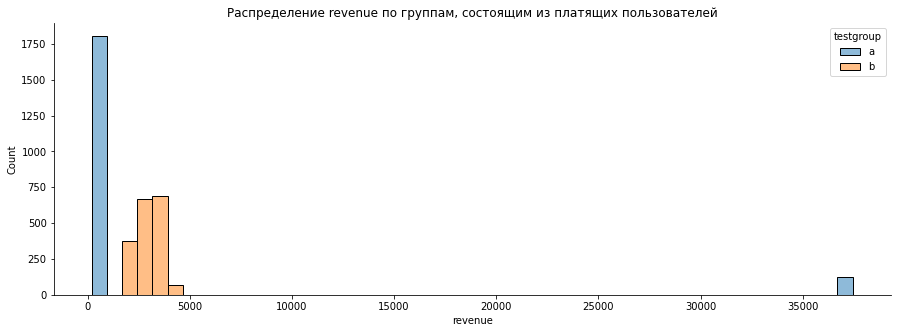

In [84]:
plt.figure(figsize=(15, 5))
sns.histplot(data=users_pay, x='revenue', hue='testgroup', bins=50) \
    .set(title='Распределение revenue по группам, состоящим из платящих пользователей')
sns.despine()

<b> Видим, что распределения не пересекаются и для контрольного распределения наблюдаем 2 диапазона значений revenue. <b/>

### Построим гистограмму только для тестовой группы.

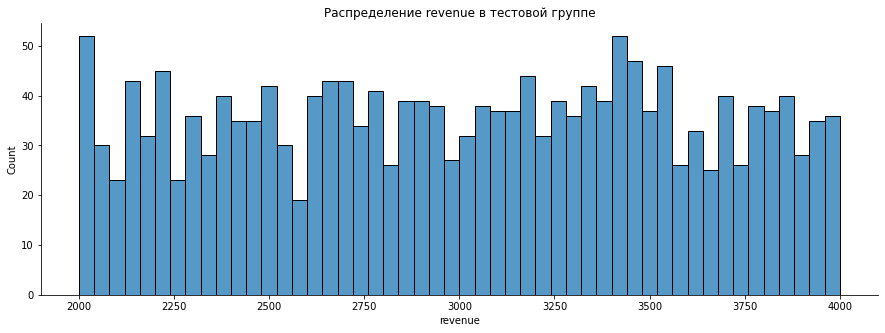

In [85]:
plt.figure(figsize=(15, 5))
sns.histplot((users_pay.query("testgroup == 'b'").revenue), bins=50) \
    .set(title='Распределение revenue в тестовой группе')
sns.despine()

Значения revenue для тестовой группы распределены равномерно в диапазоне от 2000 до 4000.

##### Построим гистограмму только для контрольной группы.

У контрольной группы есть два диапазона значений - в пределах до 1000 и более 37000. Будем смотреть оба диапазона, но сначала проверим нет ли скрытых от нашего глаза значений между двумя этими диапазонами.

In [87]:
users_pay.query("testgroup == 'a' and 1000 <= revenue <= 37000")

,user_id,revenue,testgroup


Незамеченных значений нет. Строим две гистограммы: для диапазона до 1000 и для диапазона более 37000.

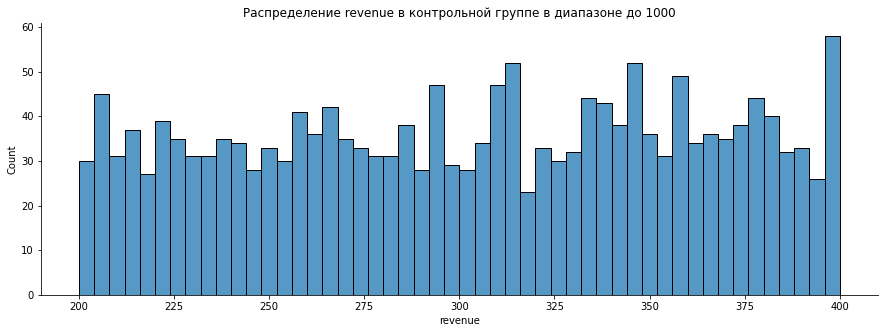

In [88]:
plt.figure(figsize=(15, 5))
sns.histplot(users_pay.query("testgroup == 'a' and revenue < 1000").revenue, bins=50) \
    .set(title='Распределение revenue в контрольной группе в диапазоне до 1000')
sns.despine()

Видим, что в диапазоне до 1000 значения revenue распределены равномерно (в промежутке от 200 до 400).

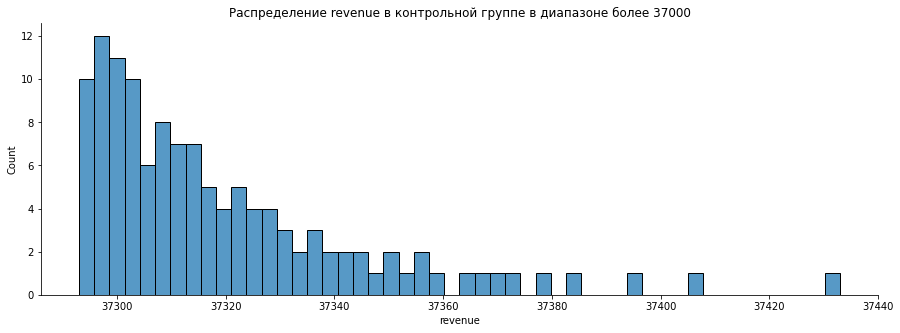

In [89]:
plt.figure(figsize=(15, 5))
sns.histplot(users_pay.query("testgroup == 'a' and revenue > 37000").revenue, bins=50) \
    .set(title='Распределение revenue в контрольной группе в диапазоне более 37000')
sns.despine()

В диапазоне более 37000 наблюдаем экспоненциально убывающее распределение значений revenue.

In [91]:
# Количество платящих пользователей в контрольной группе
users_pay.query("testgroup == 'a'").user_id.count()

1928

In [92]:
# Количество платящих пользователей c revenue > 37000 в контрольной группе
users_pay.query("testgroup == 'a' and revenue > 37000").user_id.count()

123

Странно, что в контрольную группу попали 123 пользователя с довольно сильно отличающимися значениями revenue. Присутствует ли здесь ошибка при сплитовании, которая привела к подобному распределению пользователей по группам, либо какая-то ошибка, послужившая причиной создания дублей в данных, что привело к значительному увеличению revenue, из условия неизвестно.

Все же допустим, что данные собранны корректно. Проведем тест на нормальность распределения.

In [93]:
pg.normality(data=users_pay, dv='revenue', group='testgroup', method='normaltest')

,W,pval,normal
a,1394.945784,1.234161e-303,False
b,1068.860008,7.943249e-233,False


Распределения в обеих группах статистически значимо отличаются от нормального, значение pvalue очень низкое.

##### Сравним среднее значение revenue для контрольной и тестовой группы.

In [95]:
ab_test.groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
b,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


In [96]:
rev_mean_test = ab_test.query("testgroup == 'b'").revenue.mean()
rev_mean_test.round(2)

26.75

In [97]:
rev_mean_control = ab_test.query("testgroup == 'a'").revenue.mean()
rev_mean_control.round(2)

25.41

In [98]:
ARPU_diff = ((rev_mean_test - rev_mean_control) / rev_mean_test * 100)
ARPU_diff.round(1)

5.0

Из описательной статистики видим, что среднее значение revenue составило 25.41 для контрольной группы и 26.75 - для тестовой. Таким образом, можем посчитать, что ARPU в тестовой группе на 5% больше, чем в контрольной.

##### Повторим два последних шага, но только для платящих пользователей.

In [99]:
users_pay.groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
b,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


In [100]:
rev_mean_test_pay = users_pay.query("testgroup == 'b'").revenue.mean()
rev_mean_test_pay.round(2)

3003.66

In [101]:
rev_mean_control_pay = users_pay.query("testgroup == 'a'").revenue.mean()
rev_mean_control_pay.round(2)

2664.0

In [102]:
ARPPU_diff = ((rev_mean_test_pay - rev_mean_control_pay) / rev_mean_test_pay * 100)
ARPPU_diff.round(1)

11.3

Из описательной статистики видим, что среднее значение revenue среди платящих пользователей составило 2664 для контрольной группы и 3003.66 - для тестовой. Таким образом, ARPPU в тестовой группе на 11.3% больше, чем в контрольной.

##### Сравним средние значения revenue среди всех пользователей с помощью Бутстрапа.

- Нулевая гипотеза (H0): в тестовой и контрольной группах средние значения revenue не отличаются
- Альтернативная гипотеза (H1): в тестовой и контрольной группах средние значения revenue отличаются статистически значимо

In [103]:
def bootstrap(sample_one, sample_two, sub_sample_count=1000, statistic=np.mean, value=0.95):
    
    data = []

    for _ in tqdm(range(sub_sample_count)):
        samples_1 = np.random.choice(sample_one, 
                                     size=len(sample_one), replace=True)
        samples_2 = np.random.choice(sample_two, 
                                     size=len(sample_two), replace=True)
        data.append(statistic(samples_1) - statistic(samples_2))

    pd_data = pd.DataFrame(data)

    left_quant = (1 - value) / 2
    right_quant = 1 - (1 - value) / 2
    quants = pd_data.quantile([left_quant, right_quant])

    mean_data = np.mean(data)
    std_data = np.std(data)

    p_1 = norm.cdf(x=0, loc=mean_data, scale=std_data)
    p_2 = norm.cdf(x=0, loc=-mean_data, scale=std_data)
    p_value = min(p_1, p_2) * 2
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    _, _, bars = plt.hist(pd_data[0], bins=25)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor("red")
        else:
            bar.set_facecolor("grey")
            bar.set_edgecolor("white")
    
    ax.vlines(quants,
              ymin=0,
              ymax=100,
              linestyle="--")
    
    ax.set_xlabel("Значение")
    ax.set_ylabel("Частота")
    
    plt.show()

    return p_value

In [104]:
control = ab_test.query("testgroup == 'a'")["revenue"]
test = ab_test.query("testgroup == 'b'")["revenue"]

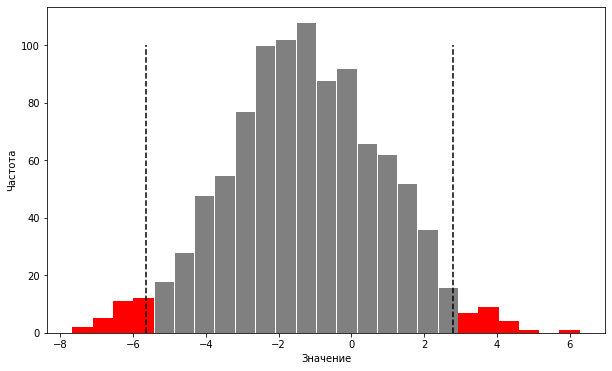

In [105]:
res = bootstrap(control, test)

In [106]:
format(res)

'0.550217669061347'

Так как p-значение больше 0,05, принимаем нулевую гипотезу, средние значения revenue среди всех пользователей в тестовой и контрольной группах не отличаются.

##### Сравним средние значения revenue среди платящих пользователей с помощью Бутстрапа.

- Нулевая гипотеза (H0): в тестовой и контрольной группах средние значения revenue не отличаются
- Альтернативная гипотеза (H1): в тестовой и контрольной группах средние значения revenue отличаются статистически значимо

In [108]:
control_pay = users_pay.query("testgroup == 'a'")["revenue"]
test_pay = users_pay.query("testgroup == 'b'")["revenue"]

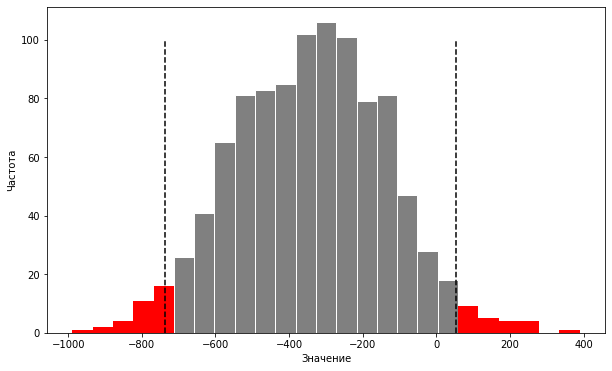

In [109]:
res_pay = bootstrap(control_pay, test_pay)

In [110]:
format(res_pay)

'0.09487143360223875'

Так как p-значение больше 0,05, принимаем нулевую гипотезу, средние значения revenue среди платящих пользователей в тестовой и контрольной группах не отличаются.

##### Сравним конверсии пользователей в покупку в тестовой и контрольной группах.

- Нулевая гипотеза (H0): в тестовой и контрольной группах конверсии пользователей в покупку не отличаются
- Альтернативная гипотеза (H1): в тестовой и контрольной группах конверсии пользователей в покупку отличаются статистически значимо

Посчитаем конверсию в покупку в контрольной группе. Для этого сначала вычислим количество платящих и общее количество пользователей в контрольной группе.

In [112]:
users_pay_a_count = users_pay.query("testgroup == 'a'").user_id.count()
users_pay_a_count


1928

In [113]:
users_all_a_count = ab_test.query("testgroup == 'a'").user_id.count()
users_all_a_count

202103

In [114]:
CR_control = ((users_pay_a_count / users_all_a_count) * 100).round(2)
CR_control

0.95

Посчитаем конверсию в покупку в тестовой группе. Для этого сначала вычислим количество платящих и общее количество пользователей в тестовой группе.

In [115]:
users_pay_b_count = users_pay.query("testgroup == 'b'").user_id.count()
users_pay_b_count

1805

In [116]:
users_all_b_count = ab_test.query("testgroup == 'b'").user_id.count()
users_all_b_count

202667

In [117]:
CR_test = ((users_pay_b_count / users_all_b_count) * 100).round(2)
CR_test

0.89

In [118]:
CR_diff = (((CR_control - CR_test) / CR_control) * 100).round(1)
CR_diff

6.3

Конверсия в покупку в контрольной группе выше на 6.3 %, чем в тестовой.

Построим таблицу сопряженности и укажем в ней количество платящих и неплатящих пользователей для каждой группы.

In [119]:
table = [[1928, 1805], [200175, 200862]]

Для проверки нулевой гипотезы воспользуемся методом Хи-квадрат.

In [120]:
ss.chi2_contingency(table)

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[  1863.89924896,   1869.10075104],
        [200239.10075104, 200797.89924896]]))

Значения pvalue = 0.04, а это значит, что мы можем отклонить нулевую гипотезу (при уровне значимости 0.05) и подтвердить, что конверсия пользователей в покупку в контрольной группе статистически значимо выше, чем в тестовой.

**Выводы:**

##### 1.Из условия было понятно, что платящих пользователей в обеих группах крайне мало (менее 1%). Выявили, что среди платящих пользователей в контрольной группе присутствуют 123 пользователя, чьи траты значительно выше трат остальных пользователей. Так как нет возможности проверить, не является ли это ошибкой, условно посчитали данные корректными.

##### 2.Средние значения revenue среди всех пользователей в тестовой и контрольной группах статистически значимо не различаются. Делаем вывод, что ARPU между группами статистически значимо не различается.

##### 3.Средние значения revenue среди платящих пользователей в тестовой и контрольной группах статистически значимо не различаются. Делаем вывод, что ARPPU между группами статистически значимо не различается.

##### 4.Конверсия пользователей в покупку в контрольной группе статистически значимо выше, чем в тестовой группе. Можем сделать вывод, что в контрольной группе пользователи активнее пользовались предложенными им акциами.

**Таким образом, набор акционных предложений в контрольной группе считаем лучшим, так как он оказался привлекательнее для пользователей, чем акционные предложения в тестовой группе (при условии, что исходные данные действительно корректны).**

### Задача 3. Предложить метрики для оценки результатов последнего прошедшего тематического события в игре

##### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Поделим метрики на метрики привлечения, активности и дохода.

**Привлечение:**
будем оценивать на сколько прошедшее тематческое событие оказалось интересным для пользователей (получило отклик) с помощью метрик:
- конверсия в тематическое событие,
- retention rate (возврат ушедших пользователей в игру после получения информации о проведении тематического события, возвращение интереса к игре).

**Активность:**
будем оценивать на сколько тематическое событие оказалось увлекательным для пользователей (насколько разнообразны и продолжительны были действия пользователей в рамках тематического события) с помощью метрик:
- retention rate (возврат ушедших пользователей в игру после получения информации о проведении тематического события),
- session length (длительность сессии),
- churn rate (отказ пользователей от участия в игре в результате проведения тематического события), 
- DAU (число уникальных пользователей за один день),
- среднее время прохождения одного уровня,
- среднее количество пройденных уровней,
- среднее количество попыток прохождения одного уровня,
- среднее количество полученных наград по видам наград,
- среднее количество пользователей, успешно прошедших все уровни тематического события.

**Доход:**
будем оценивать доход от участия пользователей в тематическом событии с помощью метрик:
- ARPU - cредний доход с одного пользователя,
- ARPPU - cредний доход с одного платящего пользователя.

##### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Для данного события будем дополнительно использовать следующие метрики:
- количество откатов в разбивке по уровням - так сможем оценить сложность прохождения уровней,
- количество повторных попыток после откатов - так сможем оценить, как долго сохраняется интерес пользователей к прохождению уровней, 
- churn rate после отката - так сможем оценить количество "нервных" пользователей, 
- разница в скорости прохождения уровня в первый раз и повторного прохождения этого же уровня после отката на него из-за ошибки в прохождении последующих уровней - просто интересно :)